In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


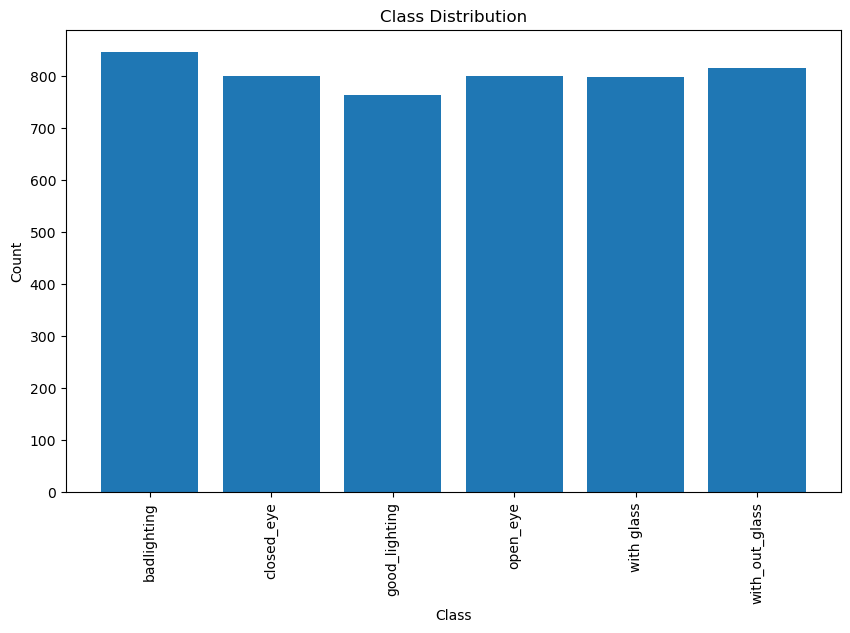

In [2]:
# Set your dataset path
dataset_path = "C:\\Users\\yashu\\Downloads\\Desktop\\final year project\\training"

# List all class folders
class_folders = os.listdir(dataset_path)

# 1. Class Distribution
# 3. Class Distribution
class_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) for folder in class_folders}
class_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(class_df['Class'], class_df['Count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Rotate x-axis labels for better visibility
plt.xticks(rotation='vertical')

plt.show()


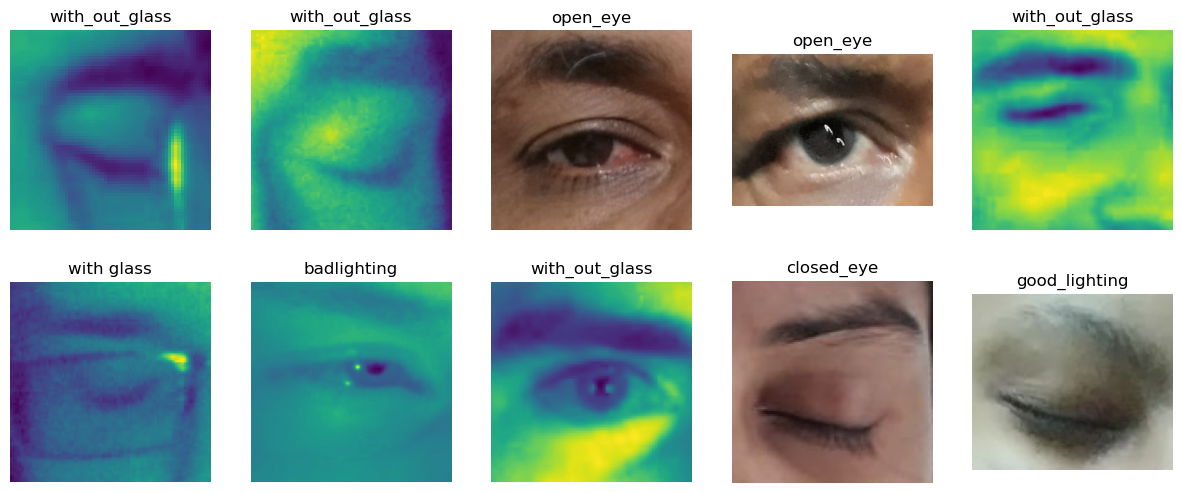

In [3]:
# 2. Image Visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        random_class = random.choice(class_folders)
        random_image = random.choice(os.listdir(os.path.join(dataset_path, random_class)))
        img = Image.open(os.path.join(dataset_path, random_class, random_image))
        axes[i, j].imshow(img)
        axes[i, j].set_title(random_class)
        axes[i, j].axis('off')
plt.show()


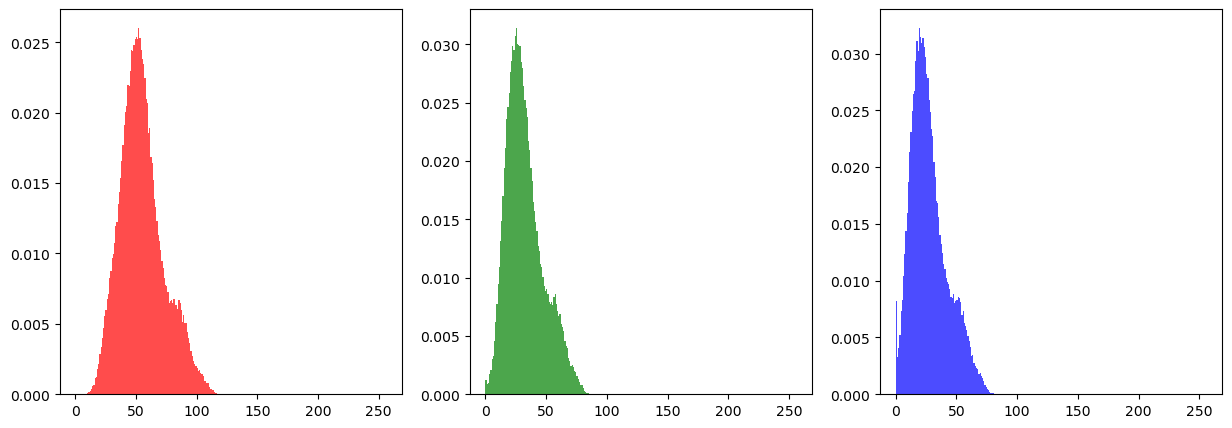

In [4]:
# 4. Color Distribution
random_image_path = os.path.join(dataset_path, random.choice(class_folders), random.choice(os.listdir(os.path.join(dataset_path, random_class))))
random_image = Image.open(random_image_path)

# Check if the image is grayscale
if random_image.mode == 'RGB':
    # Separate RGB channels
    r, g, b = random_image.split()

    # Plot histograms
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.hist(r.getdata(), bins=256, range=(0, 256), density=True, color='red', alpha=0.7)
    plt.subplot(132)
    plt.hist(g.getdata(), bins=256, range=(0, 256), density=True, color='green', alpha=0.7)
    plt.subplot(133)
    plt.hist(b.getdata(), bins=256, range=(0, 256), density=True, color='blue', alpha=0.7)
    plt.show()
else:
    # Grayscale image, plot a single histogram
    plt.figure(figsize=(8, 4))
    plt.hist(random_image.getdata(), bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.show()


In [5]:
def calculate_image_statistics(directory):
    image_dataset = image_dataset_from_directory(directory)

    image_mean = []
    image_std = []
    for images, _ in image_dataset:
        image_mean.append(np.mean(images.numpy(), axis=(0, 1, 2)))
        image_std.append(np.std(images.numpy(), axis=(0, 1, 2)))

    mean = np.mean(image_mean, axis=0)
    std = np.mean(image_std, axis=0)

    print(f"Mean pixel values: {mean}")
    print(f"Standard deviation of pixel values: {std}")
# Calculate image statistics
calculate_image_statistics(dataset_path)


Found 4823 files belonging to 6 classes.
Mean pixel values: [105.21979  93.20902  86.8705 ]
Standard deviation of pixel values: [49.990807 42.295303 40.20635 ]


In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set your dataset path
dataset_path = "C:\\Users\\yashu\\Downloads\\Desktop\\final year project\\training"

# List all class folders
class_folders = os.listdir(dataset_path)

# Encode class labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_folders)

# Print encoded class labels
print("Encoded Class Labels:")
for class_index, class_name in zip(encoded_labels, class_folders):
    print(f"Class: {class_index} - {class_name}")
# Function to load and preprocess data
def load_and_preprocess_images(dataset_path, img_size=(224, 224)):
    all_images = []
    all_labels = []

    class_samples_before = {}  # To store the number of samples before train-test split

    for class_index, class_name in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_name)

        # Count the number of samples before train-test split
        class_samples_before[class_name] = len(os.listdir(class_path))

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            # Load and preprocess the image
            img_array = cv2.imread(file_path, cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, img_size)  # Resize images to a common shape

            # Keep images and labels as lists
            all_images.append(img_array)
            all_labels.append(class_index)

    return np.array(all_images), np.array(all_labels), class_samples_before

# Load and preprocess images
img_size = (224, 224)
X, y, class_samples_before = load_and_preprocess_images(dataset_path, img_size=img_size)

# Encode labels
num_classes = len(class_folders)
encoded_labels = to_categorical(y, num_classes=num_classes)


Encoded Class Labels:
Class: 0 - badlighting
Class: 1 - closed_eye
Class: 2 - good_lighting
Class: 3 - open_eye
Class: 4 - with glass
Class: 5 - with_out_glass


In [7]:
from collections import Counter

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

# Count the number of samples after train-test split
class_samples_after_train = Counter(np.argmax(y_train, axis=1))
class_samples_after_test = Counter(np.argmax(y_test, axis=1))

# Print the number of samples before and after train-test split
print("\nNumber of samples before train-test split:")
for class_name, num_samples in class_samples_before.items():
    print(f"{class_name}: {num_samples}")

print("\nNumber of samples after train-test split (Training set):")
for class_index, class_name in enumerate(class_folders):
    print(f"{class_name}: {class_samples_after_train[class_index]}")

print("\nNumber of samples after train-test split (Test set):")
for class_index, class_name in enumerate(class_folders):
    print(f"{class_name}: {class_samples_after_test[class_index]}")



Number of samples before train-test split:
badlighting: 847
closed_eye: 800
good_lighting: 763
open_eye: 800
with glass: 798
with_out_glass: 815

Number of samples after train-test split (Training set):
badlighting: 649
closed_eye: 642
good_lighting: 626
open_eye: 660
with glass: 633
with_out_glass: 648

Number of samples after train-test split (Test set):
badlighting: 198
closed_eye: 158
good_lighting: 137
open_eye: 140
with glass: 165
with_out_glass: 167


EFFICIENT_NET

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Define input layer for eyes
input_shape = (224, 224, 3)
input_layer = layers.Input(shape=input_shape, name='input_layer')

# Load EfficientNetB0 as a base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Connect the base model to the input layer
x = base_model.output

# Flatten the output from the branch
x = layers.GlobalAveragePooling2D()(x)

# Add Dropout layer for regularization
x = layers.Dropout(0.5)(x)

# Add Dense layer for classification
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Create the final model for eyes
eyes_model = Model(inputs=input_layer, outputs=output_layer, name='efficientNet_Eye')

# Compile the model for eyes
eyes_model.compile(optimizer=Adam(learning_rate=1e-4),
                   loss=CategoricalCrossentropy(),
                   metrics=['accuracy'])

# Define callbacks for eyes model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientNet_Eye.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Train the eyes model with callbacks
history = eyes_model.fit(X_train, y_train, 
                         epochs=10, 
                         batch_size=32,
                         validation_data=(X_test, y_test),
                         callbacks=callbacks)

# Save the best optimized eyes model as "efficientNet_Eye"
eyes_model.save('efficientNet_Eye.h5')

# Save TensorFlow Lite version of the model
converter = tf.lite.TFLiteConverter.from_keras_model(eyes_model)
tflite_model = converter.convert()
with open('efficientNet_Eye.tflite', 'wb') as f:
    f.write(tflite_model)


Epoch 1/10

121/121 [==============================] - 543s 4s/step - loss: 0.9432 - accuracy: 0.6262 - val_loss: 0.9779 - val_accuracy: 0.6518 - lr: 1.0000e-04
Epoch 2/10
121/121 [==============================] - 468s 4s/step - loss: 0.5452 - accuracy: 0.7320 - val_loss: 0.6202 - val_accuracy: 0.7409 - lr: 1.0000e-04
Epoch 3/10
121/121 [==============================] - 498s 4s/step - loss: 0.4817 - accuracy: 0.7543 - val_loss: 0.4804 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 4/10
121/121 [==============================] - 464s 4s/step - loss: 0.4520 - accuracy: 0.7558 - val_loss: 0.4902 - val_accuracy: 0.7503 - lr: 1.0000e-04
Epoch 5/10
121/121 [==============================] - 481s 4s/step - loss: 0.4391 - accuracy: 0.7672 - val_loss: 0.4938 - val_accuracy: 0.7109 - lr: 1.0000e-04
Epoch 6/10
121/121 [==============================] - 477s 4s/step - loss: 0.4237 - accuracy: 0.7685 - val_loss: 0.5107 - val_accuracy: 0.7057 - lr: 1.0000e-04
Epoch 7/10
121/121 [===================

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpa2rf6cuy\assets


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [11]:
# Make predictions on the test set
y_pred = eyes_model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
class_names = [class_name for class_name in class_folders]  # Replace with your actual class names
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


31/31 [==============================] - 23s 700ms/step
Classification Report:
                 precision    recall  f1-score   support

   badlighting       0.89      0.68      0.77       198
    closed_eye       0.65      0.82      0.72       158
 good_lighting       0.06      0.01      0.02       137
      open_eye       0.68      0.98      0.80       140
    with glass       1.00      1.00      1.00       165
with_out_glass       0.70      0.90      0.79       167

      accuracy                           0.74       965
     macro avg       0.66      0.73      0.68       965
  weighted avg       0.69      0.74      0.70       965



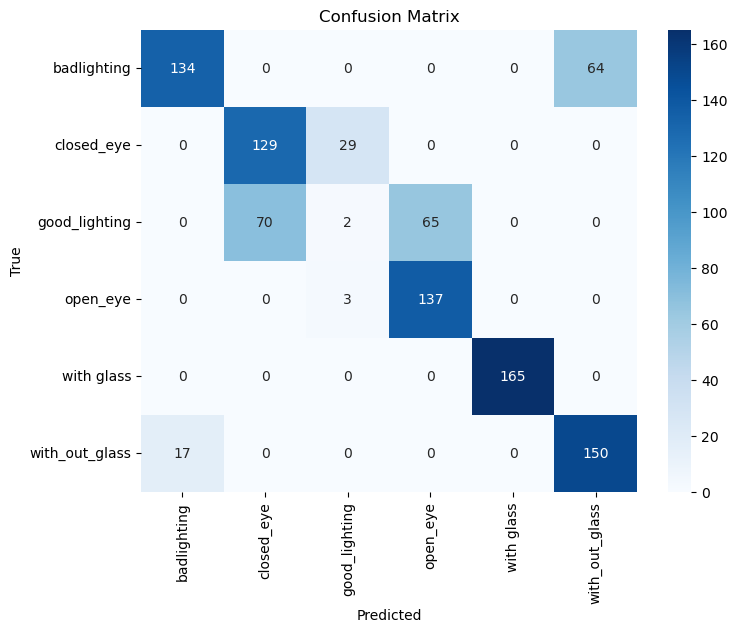

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

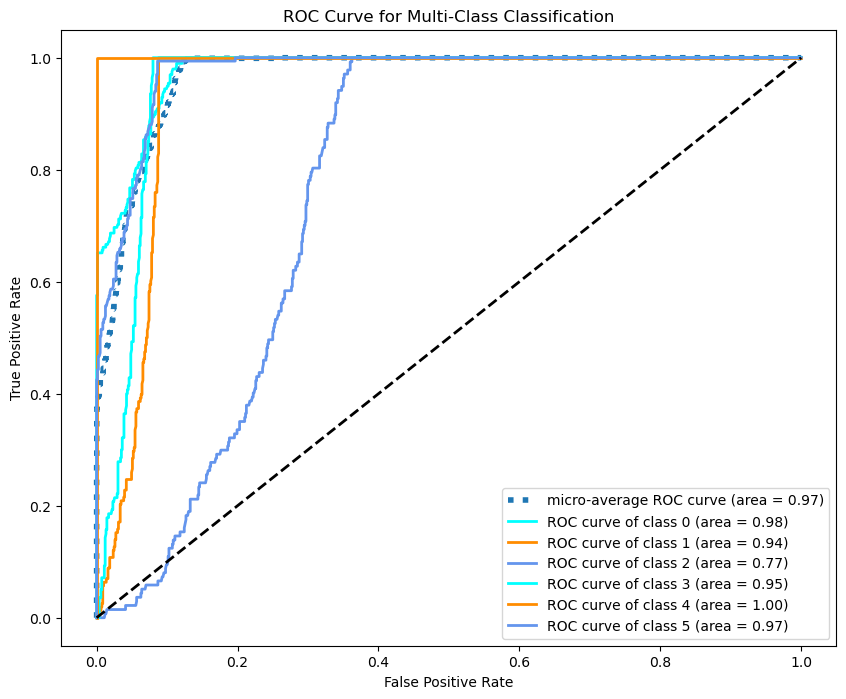

In [14]:
# ROC Curve
y_test_bin = label_binarize(y_true_classes, classes=np.arange(num_classes))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you have y_true_classes and y_pred_classes

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Recall: {recall:.4f}")


Accuracy: 0.7430
Precision: 0.6872
Recall: 0.7430


Vision Transformer (ViT):

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from datetime import datetime

# Define input layer for eyes
input_shape = (224, 224, 3)
num_classes = 6  # Replace with the actual number of classes

# Define Vision Transformer (ViT) architecture
def vision_transformer_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape, name='input_layer')
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='vision_transformer')
    return model

# Learning rate to experiment with
lr = 1e-4

# Define input layer for eyes
input_layer = layers.Input(shape=input_shape, name='input_layer')

# Build ViT model
vit_model = vision_transformer_model(input_shape, num_classes)

# Compile the model with the current learning rate
vit_model.compile(optimizer=Adam(learning_rate=lr),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

# Define callbacks for ViT model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_vit_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Measure training time
start_time = datetime.now()

# Train the ViT model with callbacks
history = vit_model.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks)

# Calculate and print the training time
end_time = datetime.now()
training_time = end_time - start_time
print(f"Training time for learning rate {lr}: {training_time}")

# Save the best ViT model
best_model_filename = 'best_vit_model.h5'
vit_model.save(best_model_filename)

# Save TensorFlow Lite version of the model
converter = tf.lite.TFLiteConverter.from_keras_model(vit_model)
tflite_model = converter.convert()
tflite_filename = 'vit_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

# Print information about the trained model
print(f"Best ViT model trained with learning rate {lr} saved as {best_model_filename}")
print(f"TensorFlow Lite version saved as {tflite_filename}")


Epoch 1/10
121/121 [==============================] - 163s 1s/step - loss: 2.7449 - accuracy: 0.2963 - val_loss: 1.2649 - val_accuracy: 0.3316 - lr: 1.0000e-04
Epoch 2/10
121/121 [==============================] - 152s 1s/step - loss: 1.2877 - accuracy: 0.3362 - val_loss: 1.1421 - val_accuracy: 0.4031 - lr: 1.0000e-04
Epoch 3/10
121/121 [==============================] - 147s 1s/step - loss: 1.2283 - accuracy: 0.3603 - val_loss: 1.1609 - val_accuracy: 0.3161 - lr: 1.0000e-04
Epoch 4/10
121/121 [==============================] - 147s 1s/step - loss: 1.2062 - accuracy: 0.3598 - val_loss: 1.1376 - val_accuracy: 0.3440 - lr: 1.0000e-04
Epoch 5/10
121/121 [==============================] - 139s 1s/step - loss: 1.1740 - accuracy: 0.3774 - val_loss: 1.0871 - val_accuracy: 0.4083 - lr: 1.0000e-04
Epoch 6/10
121/121 [==============================] - 139s 1s/step - loss: 1.1666 - accuracy: 0.3758 - val_loss: 1.0774 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 7/10
121/121 [====================

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpludru091\assets


Best ViT model trained with learning rate 0.0001 saved as best_vit_model.h5
TensorFlow Lite version saved as vit_model.tflite


In [23]:
# Make predictions on the test set
y_pred = vit_model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
class_names = [class_name for class_name in class_folders]  # Replace with your actual class names
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


31/31 [==============================] - 5s 169ms/step
Classification Report:
                 precision    recall  f1-score   support

   badlighting       0.37      0.95      0.53       198
    closed_eye       0.61      0.82      0.70       158
 good_lighting       0.33      0.21      0.26       137
      open_eye       0.63      0.61      0.62       140
    with glass       0.00      0.00      0.00       165
with_out_glass       0.55      0.07      0.12       167

      accuracy                           0.46       965
     macro avg       0.42      0.44      0.37       965
  weighted avg       0.41      0.46      0.37       965



In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you have y_true_classes and y_pred_classes

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Recall: {recall:.4f}")


Accuracy: 0.4591
Precision: 0.4092
Recall: 0.4591


31/31 [==============================] - 4s 125ms/step


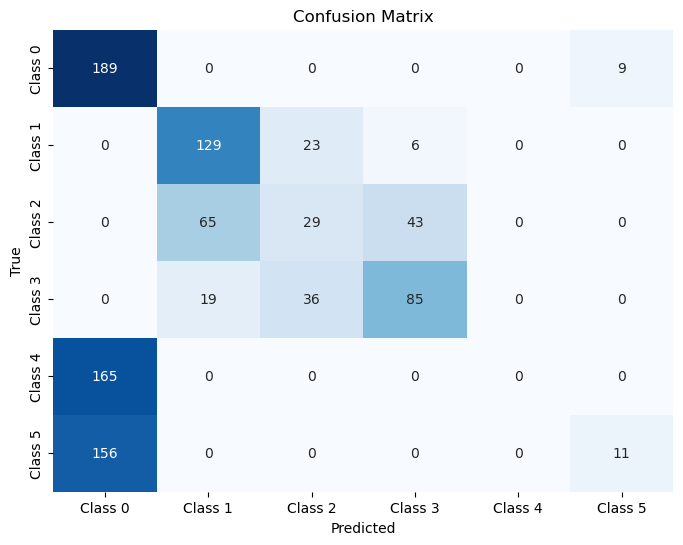

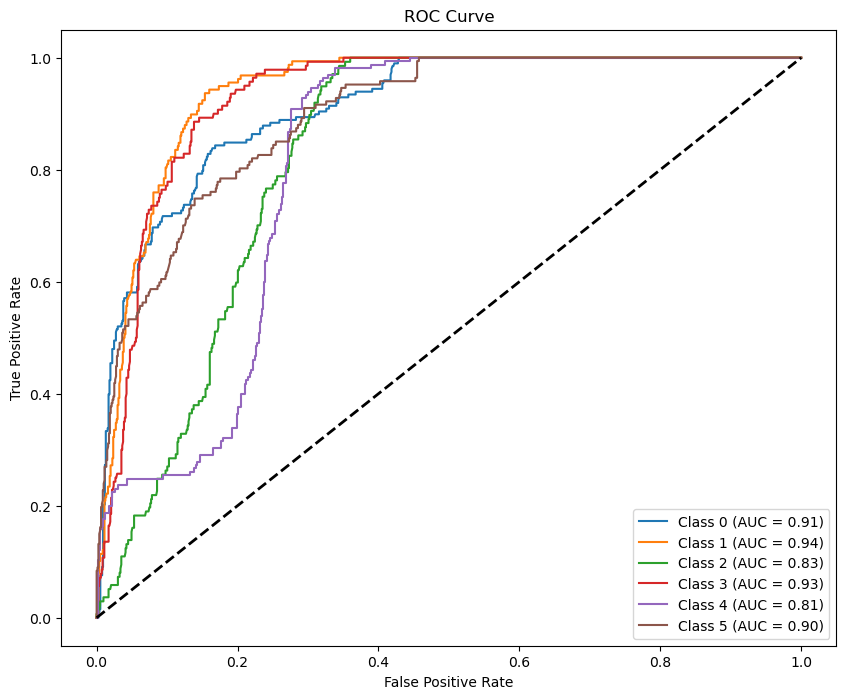

In [22]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

# Load the ViT model
loaded_model = tf.keras.models.load_model('best_vit_model.h5')
# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])],
            yticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(loaded_model.output_shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(loaded_model.output_shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


RESNET

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Define input layer for eyes
input_shape = (224, 224, 3)
num_classes = 6  # Replace with the actual number of classes

# Define ResNet50 model
def resnet_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape, name='input_layer')
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs, name='resnet_model')
    return model

# Learning rate to experiment with
lr = 1e-4

# Build ResNet50 model
resnet_model = resnet_model(input_shape, num_classes)

# Compile the model with the current learning rate
resnet_model.compile(optimizer=Adam(learning_rate=lr),
                     loss=CategoricalCrossentropy(),
                     metrics=['accuracy'])

# Define callbacks for ResNet model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Measure training time
start_time = datetime.now()

# Train the ResNet model with callbacks
history = resnet_model.fit(X_train, y_train, 
                            epochs=10, 
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            callbacks=callbacks)

# Calculate and print the training time
end_time = datetime.now()
training_time = end_time - start_time
print(f"Training time for learning rate {lr}: {training_time}")

# Save the best ResNet model
best_model_filename = 'best_resnet_model.h5'
resnet_model.save(best_model_filename)

# Save TensorFlow Lite version of the model
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()
tflite_filename = 'resnet_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

# Print information about the trained model
print(f"Best ResNet model trained with learning rate {lr} saved as {best_model_filename}")
print(f"TensorFlow Lite version saved as {tflite_filename}")




94765736/94765736 [==============================] - 14s 0us/step
Epoch 1/10


121/121 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.6654

C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 1086s 9s/step - loss: 0.7336 - accuracy: 0.6654 - val_loss: 1.2683 - val_accuracy: 0.6663 - lr: 1.0000e-04
Epoch 2/10
121/121 [==============================] - 1040s 9s/step - loss: 0.5169 - accuracy: 0.7276 - val_loss: 0.5530 - val_accuracy: 0.7254 - lr: 1.0000e-04
Epoch 3/10
121/121 [==============================] - 1037s 9s/step - loss: 0.4663 - accuracy: 0.7447 - val_loss: 0.5839 - val_accuracy: 0.7389 - lr: 1.0000e-04
Epoch 4/10
121/121 [==============================] - 1063s 9s/step - loss: 0.4356 - accuracy: 0.7548 - val_loss: 0.5125 - val_accuracy: 0.6995 - lr: 1.0000e-04
Epoch 5/10
121/121 [==============================] - 1137s 9s/step - loss: 0.4230 - accuracy: 0.7553 - val_loss: 0.5378 - val_accuracy: 0.6808 - lr: 1.0000e-04
Epoch 6/10
121/121 [==============================] - 894s 7s/step - loss: 0.4203 - accuracy: 0.7532 - val_loss: 0.5297 - val_accuracy: 0.6902 - lr: 1.0000e-04
Epoch 7/10
121/121 [==========================

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmp63melvpt\assets


Best ResNet model trained with learning rate 0.0001 saved as best_resnet_model.h5
TensorFlow Lite version saved as resnet_model.tflite


In [11]:
# Make predictions on the test set
y_pred = resnet_model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
class_names = [class_name for class_name in class_folders]  # Replace with your actual class names
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


31/31 [==============================] - 64s 2s/step
Classification Report:
                 precision    recall  f1-score   support

   badlighting       0.71      0.97      0.82       198
    closed_eye       0.60      0.66      0.63       158
 good_lighting       0.03      0.01      0.02       137
      open_eye       0.65      0.87      0.74       140
    with glass       1.00      1.00      1.00       165
with_out_glass       0.94      0.54      0.68       167

      accuracy                           0.70       965
     macro avg       0.65      0.68      0.65       965
  weighted avg       0.68      0.70      0.67       965



In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you have y_true_classes and y_pred_classes

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Recall: {recall:.4f}")


Accuracy: 0.6995
Precision: 0.6761
Recall: 0.6995


31/31 [==============================] - 61s 2s/step


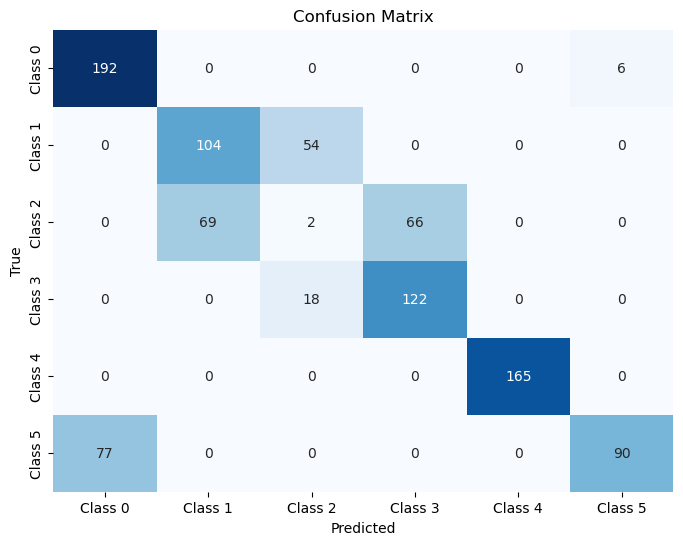

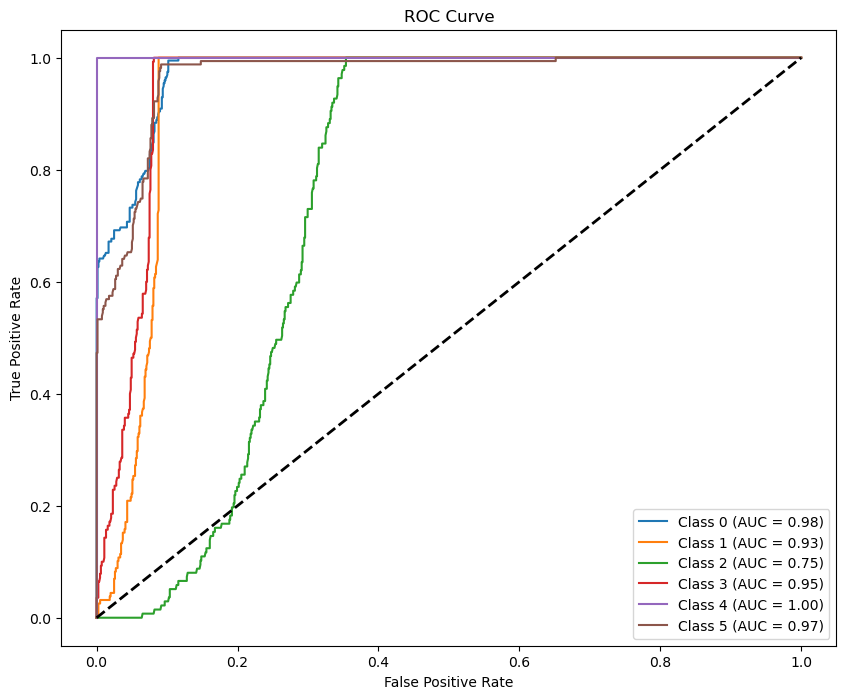

In [23]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

# Load the ViT model
loaded_model = tf.keras.models.load_model('best_resnet_model.h5')
# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])],
            yticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(loaded_model.output_shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(loaded_model.output_shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


INCEPTION V3

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Define input layer for eyes
input_shape = (224, 224, 3)
num_classes = 6  # Replace with the actual number of classes

# Define InceptionV3 model
def inception_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape, name='input_layer')
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs, name='inception_model')
    return model

# Learning rate to experiment with
lr = 1e-4

# Build InceptionV3 model
inception_model = inception_model(input_shape, num_classes)

# Compile the model with the current learning rate
inception_model.compile(optimizer=Adam(learning_rate=lr),
                        loss=CategoricalCrossentropy(),
                        metrics=['accuracy'])

# Define callbacks for Inception model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_inception_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Measure training time
start_time = datetime.now()

# Train the Inception model with callbacks
history = inception_model.fit(X_train, y_train, 
                              epochs=10, 
                              batch_size=32,
                              validation_data=(X_test, y_test),
                              callbacks=callbacks)

# Calculate and print the training time
end_time = datetime.now()
training_time = end_time - start_time
print(f"Training time for learning rate {lr}: {training_time}")

# Save the best Inception model
best_model_filename = 'best_inception_model.h5'
inception_model.save(best_model_filename)

# Save TensorFlow Lite version of the model
converter = tf.lite.TFLiteConverter.from_keras_model(inception_model)
tflite_model = converter.convert()
tflite_filename = 'inception_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

# Print information about the trained model
print(f"Best Inception model trained with learning rate {lr} saved as {best_model_filename}")
print(f"TensorFlow Lite version saved as {tflite_filename}")


Epoch 1/10
121/121 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.6594

C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 694s 5s/step - loss: 0.7376 - accuracy: 0.6594 - val_loss: 0.6641 - val_accuracy: 0.7212 - lr: 1.0000e-04
Epoch 2/10
121/121 [==============================] - 638s 5s/step - loss: 0.4943 - accuracy: 0.7346 - val_loss: 0.4926 - val_accuracy: 0.7554 - lr: 1.0000e-04
Epoch 3/10
121/121 [==============================] - 633s 5s/step - loss: 0.4535 - accuracy: 0.7506 - val_loss: 0.5357 - val_accuracy: 0.7420 - lr: 1.0000e-04
Epoch 4/10
121/121 [==============================] - 630s 5s/step - loss: 0.4325 - accuracy: 0.7501 - val_loss: 0.5272 - val_accuracy: 0.7202 - lr: 1.0000e-04
Epoch 5/10
121/121 [==============================] - 630s 5s/step - loss: 0.4309 - accuracy: 0.7574 - val_loss: 0.5315 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 6/10
121/121 [==============================] - 628s 5s/step - loss: 0.3761 - accuracy: 0.7823 - val_loss: 0.5885 - val_accuracy: 0.6808 - lr: 2.0000e-05
Epoch 7/10
121/121 [==============================]

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpg0hpdv3l\assets


Best Inception model trained with learning rate 0.0001 saved as best_inception_model.h5
TensorFlow Lite version saved as inception_model.tflite


In [14]:
# Make predictions on the test set
y_pred = inception_model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
class_names = [class_name for class_name in class_folders]  # Replace with your actual class names
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


31/31 [==============================] - 25s 761ms/step
Classification Report:
                 precision    recall  f1-score   support

   badlighting       0.83      0.68      0.75       198
    closed_eye       0.69      0.98      0.81       158
 good_lighting       0.15      0.01      0.03       137
      open_eye       0.67      0.94      0.79       140
    with glass       1.00      0.99      0.99       165
with_out_glass       0.69      0.85      0.76       167

      accuracy                           0.76       965
     macro avg       0.67      0.74      0.69       965
  weighted avg       0.69      0.76      0.71       965



In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you have y_true_classes and y_pred_classes

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Recall: {recall:.4f}")


Accuracy: 0.7554
Precision: 0.6937
Recall: 0.7554


31/31 [==============================] - 30s 919ms/step


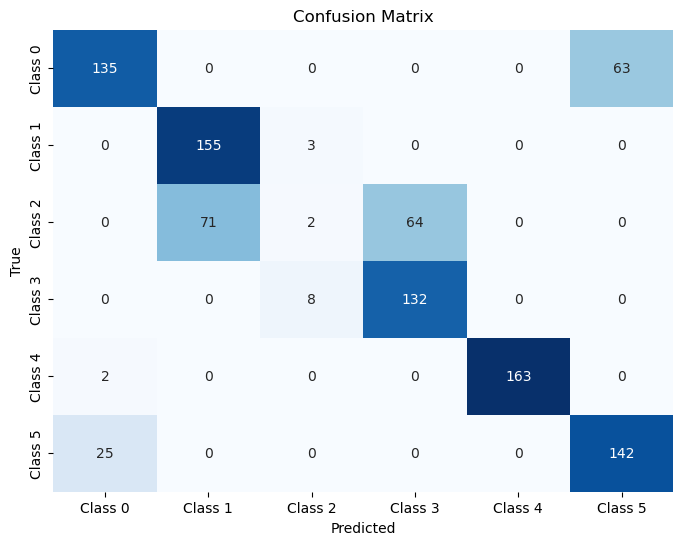

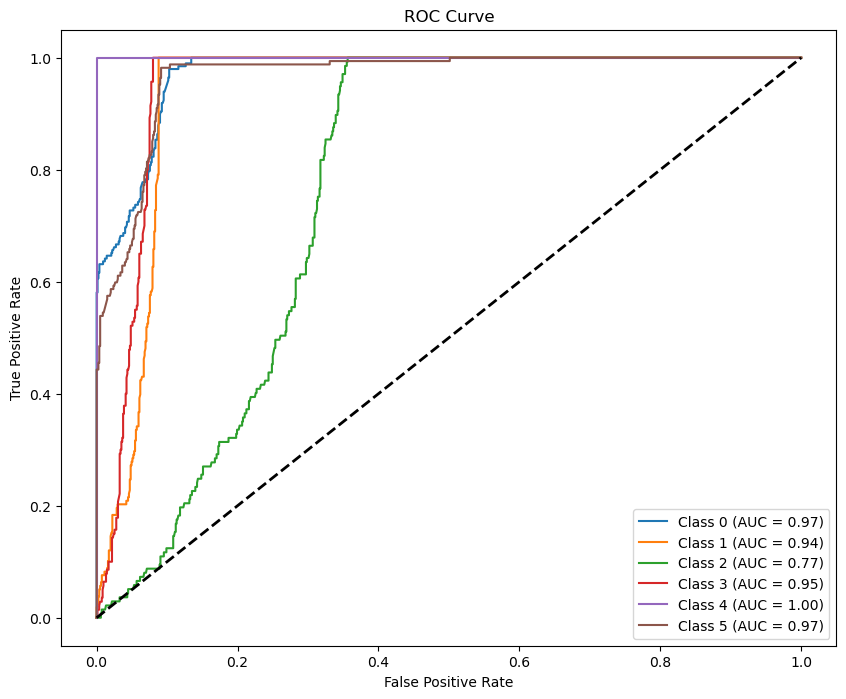

In [24]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

# Load the ViT model
loaded_model = tf.keras.models.load_model('best_inception_model.h5')
# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])],
            yticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(loaded_model.output_shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(loaded_model.output_shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


CNN

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Define input layer for eyes
input_shape = (224, 224, 3)
num_classes = 6  # Replace with the actual number of classes

# Build CNN model from scratch
cnn_model = Sequential()

# Convolutional Block 1
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

# Convolutional Block 2
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

# Convolutional Block 3
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

# Flatten the output from the convolutional layers
cnn_model.add(layers.Flatten())

# Fully Connected Layers
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
lr = 1e-4
cnn_model.compile(optimizer=Adam(learning_rate=lr),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])


# Define callbacks for CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Measure training time
start_time = datetime.now()

# Train the CNN model with callbacks
history = cnn_model.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks)

# Calculate and print the training time
end_time = datetime.now()
training_time = end_time - start_time
print(f"Training time for learning rate {lr}: {training_time}")

# Save the best CNN model
best_model_filename = 'best_cnn_model.h5'
cnn_model.save(best_model_filename)

# Save TensorFlow Lite version of the model
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()
tflite_filename = 'cnn_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

# Print information about the trained model
print(f"Best CNN model trained with learning rate {lr} saved as {best_model_filename}")
print(f"TensorFlow Lite version saved as {tflite_filename}")


Epoch 1/10
121/121 [==============================] - 163s 1s/step - loss: 35.8157 - accuracy: 0.1669 - val_loss: 1.7918 - val_accuracy: 0.1710 - lr: 1.0000e-04
Epoch 2/10
121/121 [==============================] - 157s 1s/step - loss: 1.7898 - accuracy: 0.1651 - val_loss: 1.7917 - val_accuracy: 0.1451 - lr: 1.0000e-04
Epoch 3/10
121/121 [==============================] - 159s 1s/step - loss: 1.7935 - accuracy: 0.1667 - val_loss: 1.7917 - val_accuracy: 0.1451 - lr: 1.0000e-04
Epoch 4/10
121/121 [==============================] - 161s 1s/step - loss: 1.7917 - accuracy: 0.1630 - val_loss: 1.7917 - val_accuracy: 0.1451 - lr: 1.0000e-04
Epoch 5/10
121/121 [==============================] - 153s 1s/step - loss: 1.7917 - accuracy: 0.1708 - val_loss: 1.7917 - val_accuracy: 0.1451 - lr: 2.0000e-05
Epoch 6/10
121/121 [==============================] - 161s 1s/step - loss: 1.7917 - accuracy: 0.1711 - val_loss: 1.7917 - val_accuracy: 0.1451 - lr: 2.0000e-05
Epoch 7/10
121/121 [===================

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmpis9tcgld\assets


Best CNN model trained with learning rate 0.0001 saved as best_cnn_model.h5
TensorFlow Lite version saved as cnn_model.tflite


In [18]:
# Make predictions on the test set
y_pred = cnn_model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
class_names = [class_name for class_name in class_folders]  # Replace with your actual class names
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


31/31 [==============================] - 6s 174ms/step
Classification Report:
                 precision    recall  f1-score   support

   badlighting       0.00      0.00      0.00       198
    closed_eye       0.00      0.00      0.00       158
 good_lighting       0.00      0.00      0.00       137
      open_eye       0.15      1.00      0.25       140
    with glass       0.00      0.00      0.00       165
with_out_glass       0.00      0.00      0.00       167

      accuracy                           0.15       965
     macro avg       0.02      0.17      0.04       965
  weighted avg       0.02      0.15      0.04       965



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you have y_true_classes and y_pred_classes

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')  # You can change the average parameter if needed
print(f"Recall: {recall:.4f}")


Accuracy: 0.1451
Precision: 0.0210
Recall: 0.1451


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


31/31 [==============================] - 5s 172ms/step


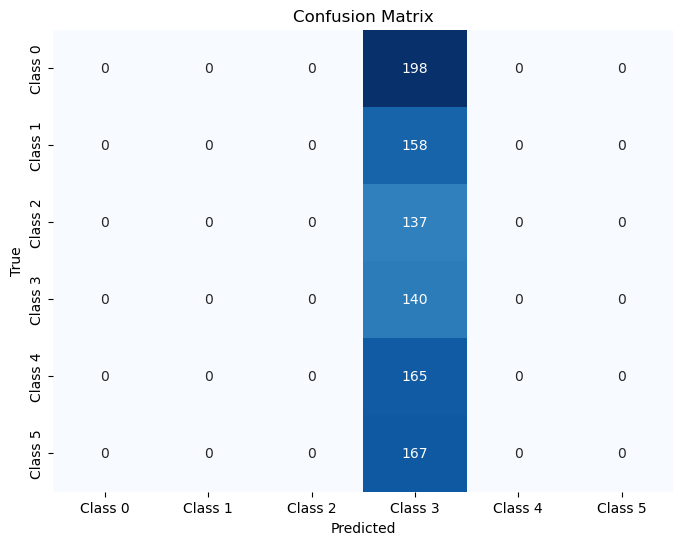

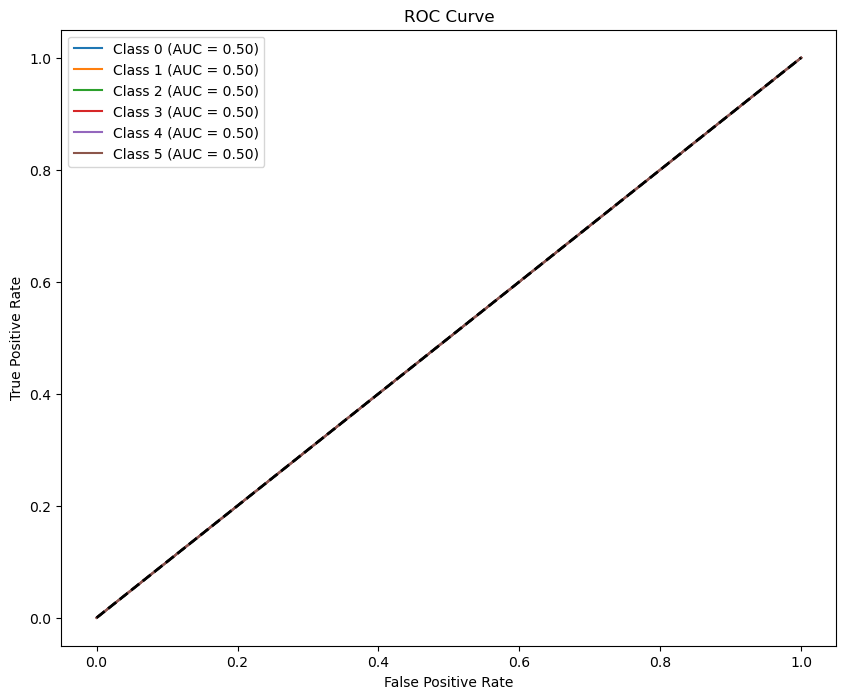

In [25]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

# Load the ViT model
loaded_model = tf.keras.models.load_model('best_cnn_model.h5')
# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])],
            yticklabels=[f'Class {i}' for i in range(conf_matrix.shape[0])])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(loaded_model.output_shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(loaded_model.output_shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


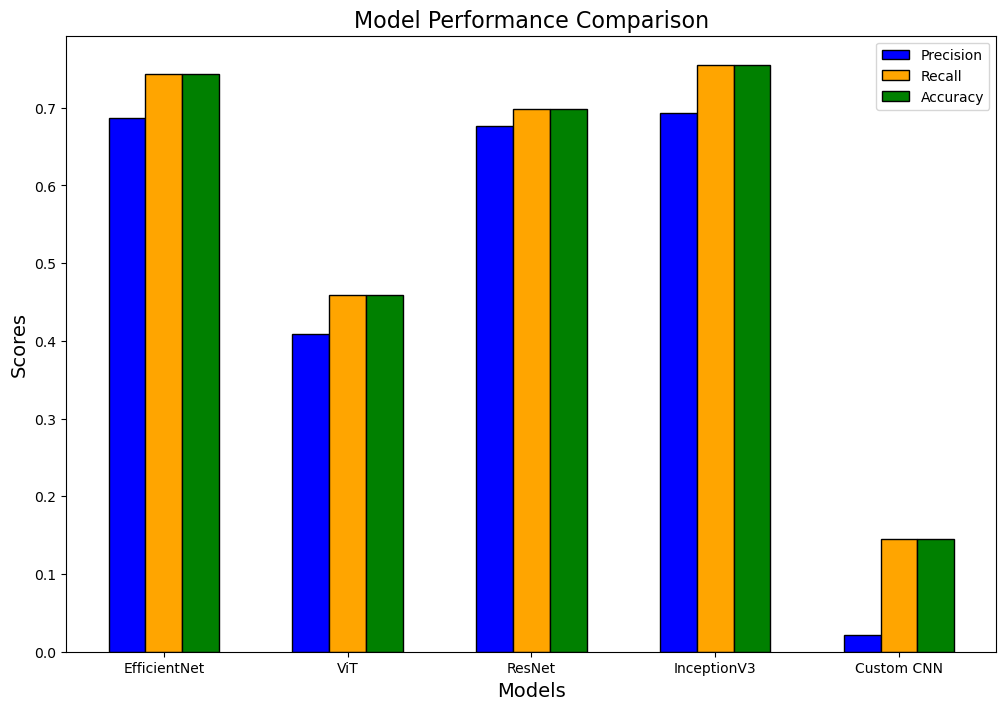

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have precision, recall, and accuracy for each model
precision_scores = [0.687, 0.409, 0.676, 0.693, 0.021]
recall_scores = [0.743, 0.459, 0.699, 0.755, 0.145]
accuracy_scores = [0.743, 0.459, 0.699, 0.755, 0.145]

models = ['EfficientNet', 'ViT', 'ResNet', 'InceptionV3', 'Custom CNN']

bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(12, 8))

# Bar graph for Precision
plt.bar(index, precision_scores, bar_width, label='Precision', color='blue', edgecolor='black')

# Bar graph for Recall
plt.bar(index + bar_width, recall_scores, bar_width, label='Recall', color='orange', edgecolor='black')

# Bar graph for Accuracy
plt.bar(index + 2 * bar_width, accuracy_scores, bar_width, label='Accuracy', color='green', edgecolor='black')

plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(index + bar_width, models)
plt.legend()
plt.show()


efficient net = 74
vision transoformer  = 46
resnet =  70
inception = 75

 transfer learning of inception V3 and effcient net

Boosting Ensemble:

Train models sequentially, where each model corrects errors made by the previous ones.
Common algorithms include AdaBoost, Gradient Boosting, and XGBoost.

Stacking Ensemble:

Train each model separately on the training set.
Use the predictions of each model as features.
Train a meta-model (e.g., logistic regression) on these features.

Voting Ensemble:

Train each model separately on the training set.
For a given input sample, let each model make a prediction.
Combine predictions using a majority voting scheme (hard voting for classification).